In [1]:
# default_exp capture

# Capture

> Wrapper class and example code for getting images from the OpenHSI using a ximea detetor (with IMX252 sensor, e.g. [MX031CG-SY](https://www.ximea.com/en/products/xilab-application-specific-custom-oem/embedded-vision-and-multi-camera-setup-xix/sony-imx252-fast-color-industrial-camera)).  

In [2]:
#hide

# documentation extraction for class methods
from nbdev.showdoc import *

# unit tests using test_eq(...)
from fastcore.test import *

# monkey patching class methods using @patch
from fastcore.foundation import *
from fastcore.foundation import patch

# imitation of Julia's multiple dispatch using @typedispatch
from fastcore.dispatch import typedispatch

In [3]:
#export
from fastcore.foundation import patch
import numpy as np
import matplotlib.pyplot as plt
from ximea import xiapi
from tqdm import tqdm
import json
from typing import Iterable, Union

/Users/eway/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
from openhsi.utils import *
from openhsi.calibrate import *

## Simulated Camera for Testing

Simulates the a camera that can return a fully illuminated image taking into account the usable area on the camera sensor. Can also return a simulated spectra. 

In [5]:
openhsi_settings = settings_load("calibration_files/settings.txt")

In [9]:
#export 

from scipy.signal.windows import gaussian

class SimulatedBasicCamera():
    """Simulated Camera for testing. Can return image of spectral lines."""
    def __init__(self,shape:tuple=(772,2064),dtype=np.uint16,row_slice:tuple=(210,680),peak:int=255):
        self.shape = shape
        self.dtype = dtype
        self.row_slice = slice(row_slice[0],row_slice[1],None)
        self.peak  = peak
        
    def get_raw_img(self,spectral_lines:Union[bool,Iterable]=False,λ_range_nm:tuple=(350,850)):
        img = np.zeros(self.shape,dtype=self.dtype)
        if spectral_lines:
            spectra = self.spectra1d(spectral_lines,λ_range_nm)
            for i in range(self.row_slice.start,self.row_slice.stop):
                img[i,:] = spectra
        else:
            img[self.row_slice,:] = self.peak
        return img
    
    def spectra1d(self,spectral_lines:list,λ_range_nm:tuple=(350,850),fwhm_nm:float=1.5,window:bool=False) -> np.array:
        # spectral_lines approx sorted by emission strength
        
        spectra = np.zeros((self.shape[1],),dtype=self.dtype)
        wavelengths = np.linspace(λ_range_nm[0],λ_range_nm[1],len(spectra))
        
        width   = np.uint16(fwhm_nm*len(spectra)/np.ptp(wavelengths))

        for i in range(len(spectral_lines)): 
            indx = np.sum(wavelengths<spectral_lines[i])
            if indx > 0 and indx < len(spectra):
                strength = self.peak if window else self.peak*np.exp(-0.15*i)
                spectra[indx-width//2:indx+width-width//2] += np.uint16(strength*gaussian(width,0.34*width))
        
        return spectra
    


In [10]:
#export 

# approx sorted by emission strength
HgAr_lines_approx_sorted = [254,436,546,764,405,365,578,750,738,697,812,772,912,801,842,795,706,826,852,727] 


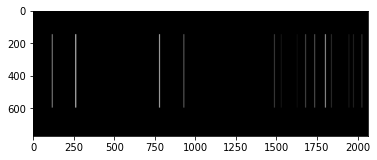

In [11]:
sbc = SimulatedBasicCamera(openhsi_settings["resolution"],row_slice=openhsi_settings["row_slice"])
plt.imshow(sbc.get_raw_img(HgAr_lines_approx_sorted,(380,820)),cmap="gray")

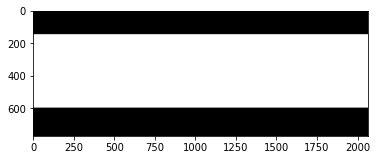

In [13]:
plt.imshow(sbc.get_raw_img(),cmap="gray")

## OpenHSI Camera

This will take images that are:
1. Cropped to the usable region (use the calibrate notebook to update this)
2. Smile corrected (again, use the calibrate notebook to update this)

You can control the:
1. Exposure time (in milliseconds)
2. Gain

In [ ]:
#export
class OpenHSI(object):
    """XIMEA camera class to change camera settings and take images"""

    def __init__(self, exposure_ms:int = 100, gain:int = 0,
                 xbinwidth:int = 896, xbinoffset:int = 528, serialnumber:str = None):
        """Init the camera"""
        
        self.xicam = xiapi.Camera()
        self.xicam.open_device_by_SN(serialnumber) if serialnumber else self.xicam.open_device()

        print(f'Connected to device {self.xicam.get_device_sn()}')

        self.xbinwidth  = xbinwidth
        self.xbinoffset = xbinoffset
        self.exposure   = exposure_ms
        self.gain       = 0

        self.xicam.set_width(self.xbinwidth)
        self.xicam.set_offsetX(self.xbinoffset)
        self.xicam.set_exposure_direct(1000*self.exposure)
        self.xicam.set_gain_direct(self.gain)

        self.xicam.set_imgdataformat("XI_RAW16")
        self.xicam.set_output_bit_depth("XI_BPP_12")
        self.xicam.enable_output_bit_packing()
        self.xicam.disable_aeag()
        
        self.xicam.set_binning_vertical(2)
        self.xicam.set_binning_vertical_mode("XI_BIN_MODE_SUM")

        self.rows, self.cols = self.xicam.get_height(), self.xicam.get_width()

        self.img = xiapi.Image()
        
        self.load_cam_settings()
        
    def __str__(self):
        return f"Connected to device {self.xicam.get_device_sn()}"

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.xicam.stop_acquisition()
        self.xicam.close_device()

    @property
    def exposure(self) -> float: # or int?
        """Current exposure in ms."""
        return self.xicam.get_exposure() / 1000

    @exposure.setter
    def exposure(self, val):
        """Update exposure in ms."""
        self.xicam.set_exposure_direct(val * 1000)

    @property
    def gain(self) -> float: # or int?
        """Current exposure property in dB from 0 to 24 dB."""
        return self.xicam.get_gain()

    @gain.setter
    def gain(self, val):
        """Update gain in dB."""
        self.xicam.set_gain_direct(val)

In [ ]:
#export
@patch
def get_raw_img(self:OpenHSI):
    self.xicam.start_acquisition()
    self.img.get_image_data_numpy()
    self.xicam.stop_acquisition()
    return self.img.get_image_data_numpy()

#### Add a method or argument to save as png

In [ ]:
#export
@patch
def load_cam_settings(self:OpenHSI,fname:str="calibration_files/settings.txt"):
    with open(fname) as json_file:
        self.settings = json.load(json_file)
    self.row_slice    = slice(self.settings["row_slice"])
    self.smile_shifts = np.array(self.settings["smile_shifts"])
    self.resolution   = self.settings["resolution"]
    
    

In [ ]:
#export 

@patch
def get_datacube(self:OpenHSI, n:int = 1, show:bool = True) -> np.ndarray:
    """Take `n` images with option to `show` first image taken."""

    self.xicam.start_acquisition()
    self.img.get_image_data_numpy()
    
    self.dc = DataCube(self.resolution,self.row_slice,n_lines=n,shifts=self.smile_shifts)

    for i in tqdm(range(n)):
        self.xicam.get_image(self.img)
        self.dc.push(self.img.get_image_data_numpy())
        
    self.xicam.stop_acquisition()
    
    if show and n > 0:
        plt.imshow(np.sum(self.dc.data,axis=1),cmap="gray")
        plt.ylabel('Along-track pixels')
        plt.xlabel('Cross-track pixels')
        plt.show()
    elif show and n==1:
        extent=(self.settings["index2wavelength_range"][0],self.settings["index2wavelength_range"][1],0,self.resolution[0])
        plt.imshow(self.dc.data[...,0],cmap="gray",extent=extent)
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Cross-track pixels')
        plt.show()
    
    return self.dc.data

### Below stuff probs doesn't work


In [ ]:
#export
@patch
def get_raw_img(self:OpenHSI, show:bool = True) -> np.ndarray:
    
    data = self.img.get_image_data_numpy()
    
    if show:
        plt.imshow(data,cmap="gray")
        plt.colorbar()
        plt.xlabel("spectra")
        plt.ylabel("cross-track")
        
    return data

In [26]:
#export
class OpenHSI(object):
    """XIMEA camera class to take images"""

    def __init__(self, serialnumber:str = None, xbinwidth:int = 896, xbinoffset:int = 528, 
                exposure_ms:int = 1000, gain:int = 0):
        """Init the camera"""
        self.xicam = xiapi.Camera()
        self.xicam.open_device_by_SN(serialnumber) if serialnumber else self.xicam.open_device()

        print(f'Connected to device {self.xicam.get_device_sn()}')

        self.xbinwidth  = xbinwidth
        self.xbinoffset = xbinoffset
        self.exposure   = exposure_ms # ms?
        self.gain       = 0

        self.xicam.set_width(self.xbinwidth)
        self.xicam.set_offsetX(self.xbinoffset)
        self.xicam.set_exposure_direct(1000*self.exposure)
        self.xicam.set_gain_direct(self.gain)

        # What other settings are there?, can we make these *args, **kwargs? and check 
        # them using getattr()
        self.xicam.set_imgdataformat("XI_RAW16")
        self.xicam.set_output_bit_depth("XI_BPP_12")
        self.xicam.enable_output_bit_packing()
        self.xicam.disable_aeag() # what is this?
        
        self.xicam.set_binning_vertical(2)
        self.xicam.set_binning_vertical_mode("XI_BIN_MODE_SUM")

        self.rows, self.cols = self.xicam.get_height(), self.xicam.get_width()

        self.img = xiapi.Image()
        self.xicam.start_acquisition()
        
        
    def __str__(self):
        return f"Connected to device {self.xicam.get_device_sn()}"

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.xicam.stop_acquisition()
        self.xicam.close_device()

    @property
    def exposure(self) -> float: # or int?
        """Current exposure in ms."""
        return self.xicam.get_exposure() / 1000

    @exposure.setter
    def exposure(self, val):
        """Update exposure in ms."""
        self.xicam.set_exposure_direct(val * 1000)

    @property
    def gain(self) -> float: # or int?
        """Current exposure property in dB from 0 to 24 dB."""
        return self.xicam.get_gain()

    @gain.setter
    def gain(self, val):
        """Update gain in dB."""
        self.xicam.set_gain_direct(val)

    # possibly put in getter and setter methods for xbinwidth and xbinoffset

    def get_img(self, n:int = 1, show:bool = True) -> np.ndarray:
        """Take `n` images with option to `show` first image taken."""
        
        data = np.zeros((self.cols,self.rows,n), dtype = np.uint16)
        for i in range(n):
            print(f'done {i}/{n}',end='\r')
            self.xicam.get_image(self.img)
            data[...,i] = np.rot90(self.img.get_image_data_numpy(), -1)
        
        if show and n > 0:
            plt.imshow(data[...,0])
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Line pixels')
            plt.show()

        return data




The `OpenHSI` class contains getters and setters to return and modify the `exposure` (in milliseconds) and `gain`. 

In [18]:
show_doc(OpenHSI.get_img)

NameError: name 'show_doc' is not defined

In [41]:
#export
def take_show(n:int=1,return_img:bool=False):
    """Grab a single image using `get_img` and plot it"""
    with OpenHSI(xbinwidth=896,xbinoffset=528,exposure_ms=100,gain=0) as cam:
        img = cam.get_img(n,show=False)
        
    if n == 1:
        plt.imshow(img[:,:,0],cmap='gray')
        plt.ylabel('Wavelength (nm)')
        plt.xlabel('Line pixels')
    elif n > 1:
        plt.imshow(np.sum(img,axis=0)[::2,:],cmap='gray')
    
    plt.show()
        
    if return_img: return img

For convience, a function is provided that initialises the camera, takes an image, and display it.  

NameError: name 'OpenHSI' is not defined

Connected to device b'XEMAS2019000'


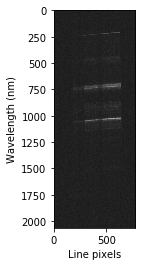

In [36]:
take_show()

Connected to device b'XEMAS2019000'


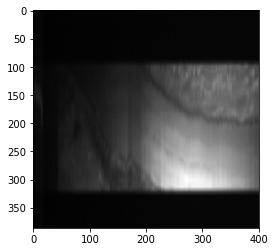

In [43]:
hcube = take_show(400,return_img=True)

In [44]:
np.shape(hcube)

(2064, 772, 400)

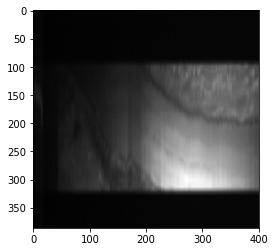

In [51]:
import pickle

with open('hcube.pkl','wb') as handle:
    pickle.dump(hcube,handle)

with open('hcube.pkl','rb') as handle:
    b = pickle.load(handle)
    
plt.imshow(np.sum(b,axis=0)[::2,:],cmap='gray')